In [1]:
# Parameters
data_url = "https://github.com/mmore500/hereditary-stratigraph-concept/blob/f21c71cc31c6cc3eed4bbd47bfce2208020ce930/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_sharingselection_seed10_pop100_mut.01_snapshot_5000.csv.gz"


In [2]:
import endomill
from nbmetalog import nbmetalog as nbm


In [3]:
nbm.print_metadata()


context: ci
hostname: cb208b65c157
interpreter: 3.8.12 (default, Jan 15 2022, 18:39:47)  [GCC 7.5.0]
nbcellexec: 3
nbname: phylogeny_reconstruction_mill
nbpath: /opt/hereditary-stratigraph-concept/binder/phylogenetic-inference/phylogeny_reconstruction_mill.ipynb
revision: null
session: 1114ef52-2d1c-4a33-92cf-2641a388ba80
timestamp: 2022-04-17T02:15:33Z00:00


IPython==7.16.1
keyname==0.4.1
yaml==5.3.1
endomill==0.1.3
nbmetalog==0.2.6
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.3.0
json==2.0.9
ipykernel==5.5.3


In [4]:
base_url = (
    'https://github.com/mmore500/hereditary-stratigraph-concept/'
    'blob/f21c71cc31c6cc3eed4bbd47bfce2208020ce930/'
    'binder/phylogenetic-inference/'
)

data_urls = [
    base_url + 'a=pairwise_mrca_estimates+source=nk_ecoeaselection_seed110_pop100_mut.01_snapshot_3000.csv.gz',
    base_url + 'a=pairwise_mrca_estimates+source=nk_lexicaseselection_seed110_pop165_mut.01_snapshot_500.csv.gz',
    base_url + 'a=pairwise_mrca_estimates+source=nk_randomselection_seed7_pop100_mut.01_snapshot_5000.csv.gz',
    base_url + 'a=pairwise_mrca_estimates+source=nk_sharingselection_seed10_pop100_mut.01_snapshot_5000.csv.gz',
    base_url + 'a=pairwise_mrca_estimates+source=nk_tournamentselection_seed140_pop100_mut.01_snapshot_5000.csv.gz',
]

endomill.instantiate_over(
    parameter_packs=[
        {'data_url': data_url}
        for data_url in data_urls
    ],
)


detected executing.endomill.ipynb file
skipping instantiate_over


In [5]:
#define papermil parameters
data_url: str


In [6]:
import alifedata_phyloinformatics_convert as apc
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
from collections import Counter
from iterpop import iterpop as ip
import itertools as it
from keyname import keyname as kn
from matplotlib import pyplot as plt
import numpy as np
from os.path import basename
import pandas as pd
import sys
from teeplot import teeplot as tp
from tqdm import tqdm
import warnings


In [7]:
from pylib import draw_biopython_tree_with_origin_time_bounds


In [8]:
nbm.print_metadata()


context: ci
hostname: cb208b65c157
interpreter: 3.8.12 (default, Jan 15 2022, 18:39:47)  [GCC 7.5.0]
nbcellexec: 8
nbname: phylogeny_reconstruction_mill
nbpath: /opt/hereditary-stratigraph-concept/binder/phylogenetic-inference/phylogeny_reconstruction_mill.ipynb
revision: null
session: 1114ef52-2d1c-4a33-92cf-2641a388ba80
timestamp: 2022-04-17T02:15:34Z00:00


IPython==7.16.1
endomill==0.1.3
ipykernel==5.5.3
ipython_genutils==0.2.0
json==2.0.9
keyname==0.4.1
logging==0.5.1.2
nbmetalog==0.2.6
re==2.2.1
yaml==5.3.1
zmq==22.3.0
Bio==1.79
alifedata_phyloinformatics_convert==0.6.0
iterpop==0.4.0
matplotlib==3.3.2
numpy==1.21.5
pandas==1.1.2
teeplot==0.2.0


In [9]:
df = pd.read_csv(
    f'{data_url}?raw=true',
    compression='gzip',
)

nbm.print_dataframe_synopsis(df)

data_filename = basename(data_url)

print(data_filename)


digest: 203b999485e5eea02cb866a6d7c77d48a28491f29c4878147930240148ea2d85
manifest:
  Column Configuration: '                              18#     ex., actual_bits=63+actual_strata=63+bits_error=-1+differentia=1+policy=TaperedDepthProportionalResolution+resolution=31+target_bits=64'
  Differentia Bit Width: '                             3#      ex., 1'
  Generation Of MRCA Lower Bound (inclusive): '        45#     ex., 4800'
  Generation Of MRCA Upper Bound (exclusive): '        32#     ex., 5001'
  Generation of Taxon Compared From: '                 3#      ex., 5001'
  Generation of Taxon Compared To: '                   3#      ex., 5001'
  MRCA Bound Confidence: '                             3#      ex., 0.96875'
  Rank of Earliest Detectable Mrca With: '             6#      ex., 512'
  Stratigraphic Column Actual Num Retained Strata: '   7#      ex., 63'
  Stratigraphic Column Expected Retained Bits: '       14#     ex., 63'
  Stratigraphic Column Expected Retained Bits Error: ' 9

In [10]:
endomill.add_instance_outpath(
    f'a=phylogeny_reconstruction+source={kn.unpack(data_filename)["source"]}.endomill.ipynb'
)


In [11]:
df['Treatment'] = df.apply(
    lambda row: kn.pack({
        'target': row['Stratigraphic Column Target Retained Bits'],
        'differentia': row['Differentia Bit Width'],
        'policy': row['Stratum Retention Policy'],
    }),
    axis=1,
)


In [12]:
max_gen = df['Generation of Taxon Compared From'].max()


In [13]:
def create_distance_matrix(df):
    assert len(df['Treatment'].unique() == 1)

    counter = it.count()
    taxon_to_index = {
        taxon : next(counter)
        for taxon in df['Taxon Compared From'].unique()
    }
    label_list = sorted(
        [*df['Taxon Compared From'].unique()],
        key=lambda x: taxon_to_index[x],
    )
    assert len(label_list) == len(taxon_to_index)

    def row_to_mrca_time_mid(row):
        mrca_lb = row['Generation Of MRCA Lower Bound (inclusive)']
        mrca_ub = row['Generation Of MRCA Upper Bound (exclusive)']
        earliest_detectable_mrca = row['Rank of Earliest Detectable Mrca With']
        taxon1_gen = row['Generation of Taxon Compared From']
        taxon2_gen = row['Generation of Taxon Compared To']

        if not np.isnan(mrca_lb) and not np.isnan(mrca_ub):
            return (mrca_lb + mrca_ub - 1) / 2 # ub is exclusive
        elif earliest_detectable_mrca == 0:
            # we are confident that no mrca exists, but return 0
            return 0
        elif np.isnan(mrca_ub) and not np.isnan(earliest_detectable_mrca):
            assert np.isnan(mrca_lb)
            return (earliest_detectable_mrca - 1) / 2 # exclusive
        else:
            assert np.isnan(mrca_lb) and np.isnan(mrca_ub) and np.isnan(earliest_detectable_mrca)
            ub = min(taxon1_gen, taxon2_gen)
            return ub / 2
    mrca_time_mid_dict = {
        (row['Taxon Compared From'], row['Taxon Compared To']):
             row_to_mrca_time_mid(row)
        for __, row in df.iterrows()
    }
    assert not any(np.isnan(x) for x in mrca_time_mid_dict.values())

    distance_dict = {
        (taxon_to_index[row['Taxon Compared From']], taxon_to_index[row['Taxon Compared To']]):
            row['Generation of Taxon Compared From']
            + row['Generation of Taxon Compared To']
            - 2 * mrca_time_mid_dict[
                (row['Taxon Compared From'], row['Taxon Compared To'])
            ]
        for __, row in df.iterrows()
    }
    assert not any(np.isnan(x) for x in distance_dict.values())

    distance_matrix = np.array([
        [
            float(distance_dict[(i, j)] + distance_dict[(j, i)])
            if i != j
            else 0.0
            for j in range(len(taxon_to_index))
        ]
        for i in range(len(taxon_to_index))
    ])

    return distance_matrix, label_list


In [14]:
def to_tril(matrix):
    return [
        row[:row_idx] + [0]
        for row_idx, row in enumerate(matrix.tolist())
    ]


In [15]:
def distance_construct_tree(df, algorithm):
    def row_to_mrca_time_lb(row):
        mrca_lb = row['Generation Of MRCA Lower Bound (inclusive)']
        if not np.isnan(mrca_lb):
            return mrca_lb
        else:
            assert np.isnan(row['Generation Of MRCA Upper Bound (exclusive)'])
            return 0
    mrca_time_lb_dict = {
        (row['Taxon Compared From'], row['Taxon Compared To']):
            row_to_mrca_time_lb(row)
        for __, row in df.iterrows()
    }
    assert not any(np.isnan(x) for x in mrca_time_lb_dict.values())

    def row_to_mrca_time_ub(row):
        mrca_ub = row['Generation Of MRCA Upper Bound (exclusive)']
        earliest_detectable_mrca = row['Rank of Earliest Detectable Mrca With']
        taxon1_gen = row['Generation of Taxon Compared From']
        taxon2_gen = row['Generation of Taxon Compared To']
        if not np.isnan(mrca_ub):
            return mrca_ub
        elif not np.isnan(earliest_detectable_mrca):
            return earliest_detectable_mrca
        else:
            assert np.isnan(mrca_ub) and np.isnan(earliest_detectable_mrca)
            return min(taxon1_gen, taxon2_gen) + 1 #exclusive
    mrca_time_ub_dict = {
        (row['Taxon Compared From'], row['Taxon Compared To']):
            row_to_mrca_time_ub(row)
        for __, row in df.iterrows()
    }
    assert not any(np.isnan(x) for x in mrca_time_ub_dict.values())

    for __, row in df.iterrows():
        mrca_time_lb_dict[(row['Taxon Compared From'], row['Taxon Compared From'])] \
            = row['Generation of Taxon Compared From'] # inclusive
        mrca_time_ub_dict[(row['Taxon Compared From'], row['Taxon Compared From'])] \
            = row['Generation of Taxon Compared From'] + 1 # exclusive


    assert len(df['Treatment'].unique() == 1)
    distance_matrix, label_list = create_distance_matrix(df)
    assert not np.isnan(distance_matrix.sum())
    dm = DistanceMatrix([*map(str, label_list)], to_tril(distance_matrix))
    tree = getattr(DistanceTreeConstructor(), algorithm)(dm)

    # fixup orign times
    for node in tree.find_clades():
        node.origin_time_lbs = []
        node.origin_time_ubs = []

    for leaf1, leaf2 in it.product(tree.get_terminals(), tree.get_terminals()):
        mrca_node = tree.common_ancestor(leaf1, leaf2)
        if leaf1 == leaf2:
            assert mrca_node == leaf1

        mrca_time_lb = mrca_time_lb_dict[(int(leaf1.name), int(leaf2.name))]
        assert not np.isnan(mrca_time_lb)
        mrca_node.origin_time_lbs.append(mrca_time_lb)

        mrca_time_ub = mrca_time_ub_dict[(int(leaf1.name), int(leaf2.name))]
        assert not np.isnan(mrca_time_ub)
        mrca_node.origin_time_ubs.append(mrca_time_ub)

    for node in tree.find_clades():
        assert node.origin_time_lbs
        assert node.origin_time_ubs

        # upper bound is a hard bound,
        # so anything above the lowest upper bound
        # is strictly impossible
        node.origin_time_ub = np.min(node.origin_time_ubs)

        # to calculate the consolidated lower bound
        # find all bounds with an upper component that is
        # has not been undercut
        # and then pick the strictest among those
        node.origin_time_lb = np.max([
            lb
            for lb, ub in zip(
                node.origin_time_lbs,
                node.origin_time_ubs,
            )
            if ub <= node.origin_time_ub
        ])

        assert node.origin_time_ub > node.origin_time_lb

        node.origin_time_est = np.mean([node.origin_time_lb, node.origin_time_ub - 1])

    # reroot tree
    new_root = min(tree.find_clades(), key=lambda node: node.origin_time_est)
    tree.root_with_outgroup(new_root)

    # fixup branch lengths
    tree.root.branch_length = tree.root.origin_time_est
    for node in tree.find_clades():
        for child in node.clades:
            child.branch_length = child.origin_time_est - node.origin_time_est

    # sort clades for consistent display
    for node in tree.find_clades(order='postorder'):
        if node.clades:
            node.max_descendant = max(child.max_descendant for child in node.clades)
        else:
            node.max_descendant = int(node.name)
        node.clades.sort(key=lambda node: node.max_descendant)

    return tree


In [16]:
def nj(df): return distance_construct_tree(df, 'nj')
def upgma(df): return distance_construct_tree(df, 'upgma')

trees = {
    (treatment, algorithm): algorithm(group)
    for treatment, group in tqdm(df.groupby('Treatment'))
    for algorithm in (
        # disabled nj due to obvious discrepancies
        # with respect to origin time of internal nodes
        # that break assertions
        # nj,
        upgma,
    )
}


  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:02<00:43,  2.58s/it]

 11%|█         | 2/18 [00:05<00:41,  2.57s/it]

 17%|█▋        | 3/18 [00:07<00:38,  2.57s/it]

 22%|██▏       | 4/18 [00:10<00:35,  2.57s/it]

 28%|██▊       | 5/18 [00:12<00:33,  2.59s/it]

 33%|███▎      | 6/18 [00:15<00:31,  2.59s/it]

 39%|███▉      | 7/18 [00:18<00:28,  2.58s/it]

 44%|████▍     | 8/18 [00:20<00:25,  2.58s/it]

 50%|█████     | 9/18 [00:23<00:23,  2.58s/it]

 56%|█████▌    | 10/18 [00:25<00:20,  2.58s/it]

 61%|██████    | 11/18 [00:28<00:18,  2.59s/it]

 67%|██████▋   | 12/18 [00:31<00:15,  2.59s/it]

 72%|███████▏  | 13/18 [00:33<00:12,  2.58s/it]

 78%|███████▊  | 14/18 [00:36<00:10,  2.58s/it]

 83%|████████▎ | 15/18 [00:38<00:07,  2.58s/it]

 89%|████████▉ | 16/18 [00:41<00:05,  2.58s/it]

 94%|█████████▍| 17/18 [00:43<00:02,  2.58s/it]

100%|██████████| 18/18 [00:46<00:00,  2.58s/it]

100%|██████████| 18/18 [00:46<00:00,  2.58s/it]

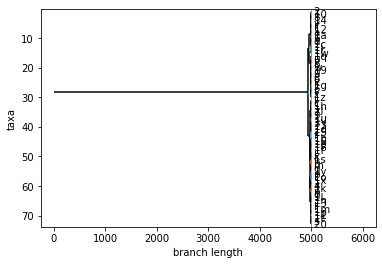

teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%4096+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%4096+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

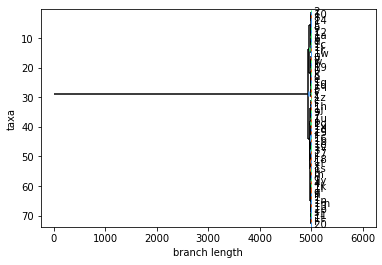

teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%512+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%512+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

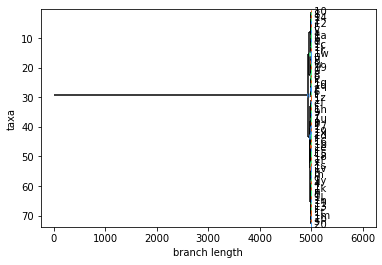

teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%64+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%64+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

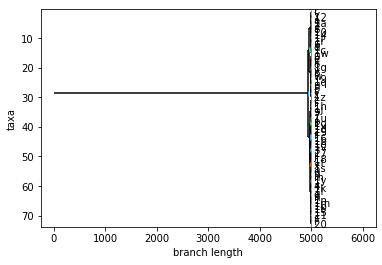

teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%4096+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%4096+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

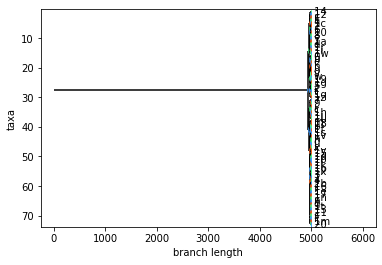

teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%512+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%512+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

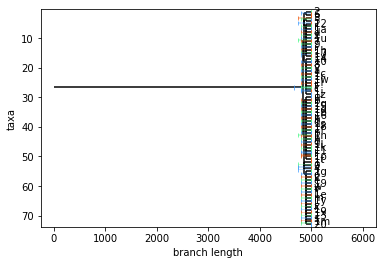

teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%64+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%64+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

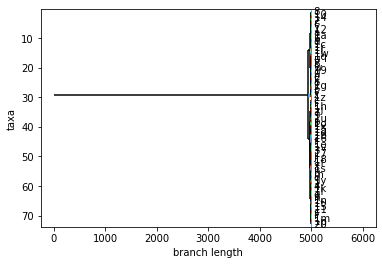

teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%4096+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%4096+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

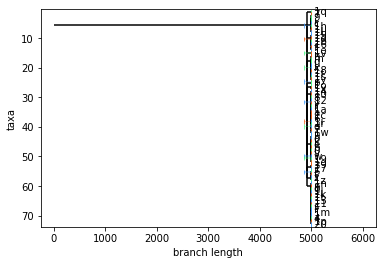

teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%512+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%512+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

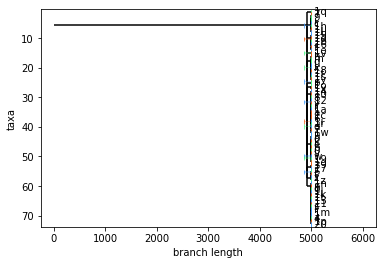

teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%64+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%64+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

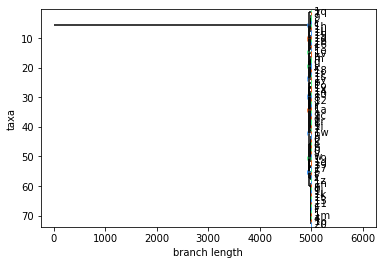

teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%4096+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%4096+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

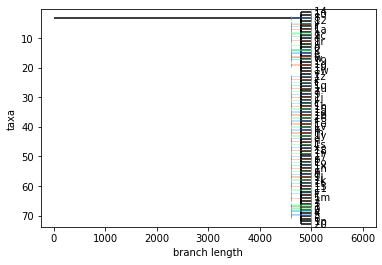

teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%512+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%512+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

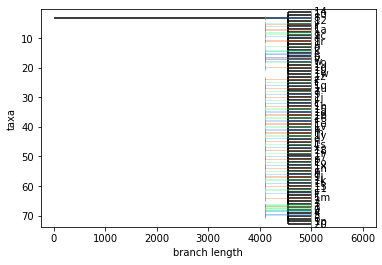

teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%64+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%64+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

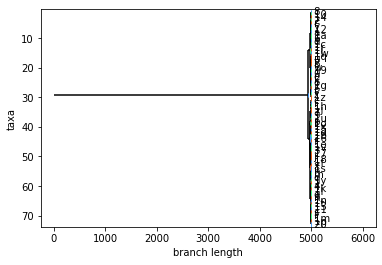

teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%4096+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%4096+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

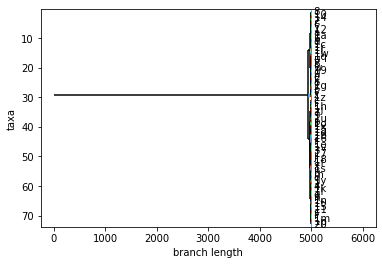

teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%512+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%512+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

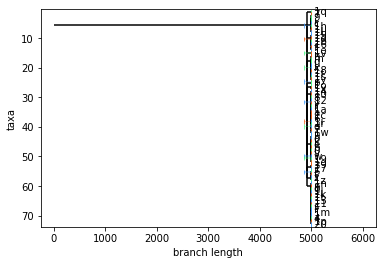

teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%64+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%64+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

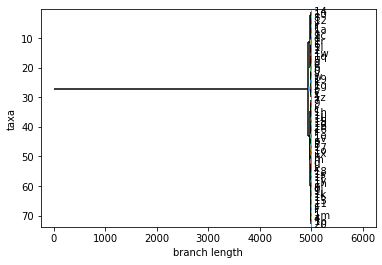

teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%4096+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%4096+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

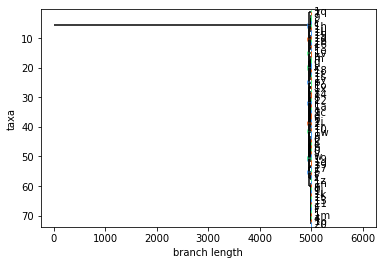

teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%512+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%512+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

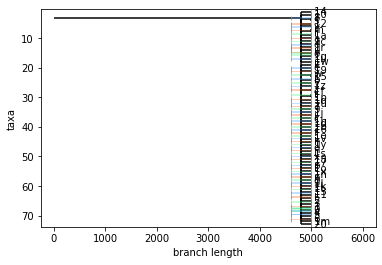

teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%64+viz=draw-biopython-tree-with-origin-time-bounds+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%64+viz=draw-biopython-tree-with-origin-time-bounds+ext=.png


<Figure size 432x288 with 0 Axes>

In [17]:
taxon_rename_dict = {
    str(taxon): np.base_repr(i, 36).lower()
    for i, taxon
    in enumerate(sorted(df['Taxon Compared From'].unique()))
}
for (treatment, algorithm), tree in trees.items():
    tp.tee(
        draw_biopython_tree_with_origin_time_bounds,
        tree,
        label_func=lambda node: None if 'Inner' in str(node) else taxon_rename_dict[str(node)],
        teeplot_outattrs={
            'algorithm' : algorithm.__name__,
            'treatment' : kn.demote(treatment),
        },
    )
    plt.show()


In [18]:
alife_dataframes = {
    (treatment, algorithm): apc.biopython_tree_to_alife_dataframe(
        tree,
        exportattrs={
            'origin_time_lb': 'Origin Time Lower Bound (Inclusive)',
            'origin_time_ub': 'Origin Time Upper Bound (Exclusive)',
            'origin_time_est': 'Origin Time Estimate',
        }
    )
    for (treatment, algorithm), tree in trees.items()
}
for (treatment, algorithm), df in alife_dataframes.items():
    df['Treatment'] = treatment
    df['Algorithm'] = algorithm


In [19]:
res_df = pd.concat(alife_dataframes.values()).reset_index()


In [20]:
res_df


,index,id,ancestor_list,origin_time,branch_length,name,Origin Time Lower Bound (Inclusive),Origin Time Upper Bound (Exclusive),Origin Time Estimate,Treatment,Algorithm
0,0,0,[None],4944.0,4944.0,Inner72,4942,4947,4944.0,differentia=1+policy=RecencyProportionalResolu...,<function upgma at 0x7f99597dfdc0>
1,1,1,[0],4967.0,23.0,Inner71,4965,4970,4967.0,differentia=1+policy=RecencyProportionalResolu...,<function upgma at 0x7f99597dfdc0>
2,2,2,[1],4990.0,23.0,Inner62,4988,4993,4990.0,differentia=1+policy=RecencyProportionalResolu...,<function upgma at 0x7f99597dfdc0>
3,3,3,[2],4992.0,2.0,Inner55,4990,4995,4992.0,differentia=1+policy=RecencyProportionalResolu...,<function upgma at 0x7f99597dfdc0>
4,4,4,[3],4993.0,1.0,Inner50,4991,4996,4993.0,differentia=1+policy=RecencyProportionalResolu...,<function upgma at 0x7f99597dfdc0>
...,...,...,...,...,...,...,...,...,...,...,...
2605,140,140,[138],5000.0,197.0,316570,5000,5001,5000.0,differentia=8+policy=TaperedDepthProportionalR...,<function upgma at 0x7f99597dfdc0>
2606,141,141,[133],5000.0,197.0,316573,5000,5001,5000.0,differentia=8+policy=TaperedDepthProportionalR...,<function upgma at 0x7f99597dfdc0>
2607,142,142,[132],5000.0,197.0,316581,5000,5001,5000.0,differentia=8+policy=TaperedDepthProportionalR...,<function upgma at 0x7f99597dfdc0>
2608,143,143,[129],5001.0,198.0,316640,5001,5002,5001.0,differentia=8+policy=TaperedDepthProportionalR...,<function upgma at 0x7f99597dfdc0>


In [21]:
nbm.print_dataframe_synopsis(res_df)


digest: 7336657dde727c7da00a40002f3b7d61c91b1302ae39b2faa389b33eacd87488
manifest:
  Algorithm: '                           1#    ex., <function upgma at 0x7f99597dfdc0>'
  Origin Time Estimate: '                61#   ex., 4944.0'
  Origin Time Lower Bound (Inclusive): ' 45#   ex., 4942'
  Origin Time Upper Bound (Exclusive): ' 33#   ex., 4947'
  Treatment: '                           18#   ex., differentia=1+policy=RecencyProportionalResolution+target=4096'
  ancestor_list: '                       142#  ex., [None]'
  branch_length: '                       77#   ex., 4944.0'
  id: '                                  145#  ex., 0'
  index: '                               145#  ex., 0'
  name: '                                145#  ex., Inner72'
  origin_time: '                         61#   ex., 4944.0'
num cols: 11
num cols all na: 0
num cols any na: 0
num na: 0
num rows: 2610
num rows all na: 0
num rows any na: 0
size: 1M



In [22]:
res_df.to_csv(
    f'a=reconstructed_phylogenies+source={kn.unpack(data_filename)["source"]}',
    compression='gzip',
)
res_df.to_csv(
    f'a=reconstructed_phylogenies+source={kn.unpack(data_filename)["source"][:-len(".gz")]}',
)
